# Closed-Loop Echolocation with snntorch

This notebook builds a simplified closed-loop bat echolocation system that spans **vocal-motor pulse generation** and **auditory coincidence detection** (Jeffress-style place coding in the Inferior Colliculus). It demonstrates how timing alone maps range to space in a spiking network.

## Part 1: The FM Signal (Physics)
- Linear FM chirp generator: `generate_chirp(duration, f_start, f_end)`
- Doppler shift for a moving target; echo delayed by time-of-flight.
- Spectrograms show outgoing chirp vs. incoming echo.

In [12]:
import numpy as np
import torch
import snntorch as snn
from snntorch import spikeplot
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

%matplotlib inline

/Users/jackhenry/Library/CloudStorage/OneDrive-UniversityofCambridge/IIB Project work/Bat_model/.bat_venv/lib/python3.12/site-packages/matplotlib/axes/_axes.py:8283: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


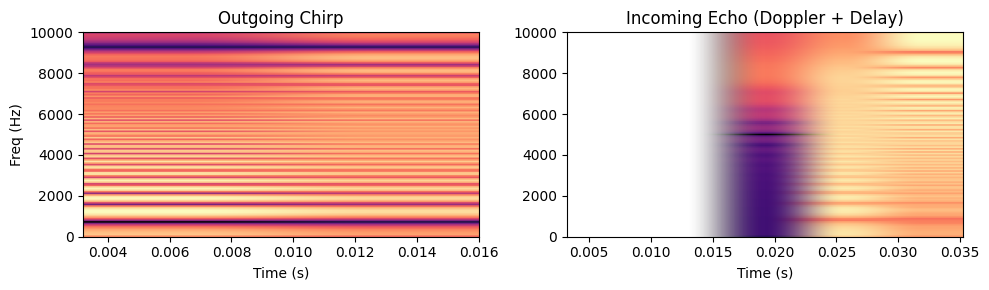

In [13]:
sound_speed = 343.0  # m/s
fs = 20000           # sample rate for spectrograms (Hz)

def generate_chirp(duration: float, f_start: float, f_end: float, fs: int = fs):
    t = np.linspace(0, duration, int(duration * fs), endpoint=False)
    k = (f_end - f_start) / duration
    phase = 2 * np.pi * (f_start * t + 0.5 * k * t ** 2)
    chirp = np.sin(phase)
    return t, chirp

def doppler_echo(chirp: np.ndarray, delay_s: float, v_target: float, f_start: float, f_end: float, fs: int = fs):
    """Apply a Doppler shift (approx) and delay the chirp to simulate an echo."""
    factor = 1 + v_target / sound_speed  # v_target >0 means receding (lower freq), <0 approaching (higher freq)
    duration = len(chirp) / fs
    t = np.linspace(0, duration, len(chirp), endpoint=False)
    k = ((f_end * factor) - (f_start * factor)) / duration
    phase = 2 * np.pi * ((f_start * factor) * t + 0.5 * k * t ** 2)
    shifted = np.sin(phase)

    delay_samples = int(round(delay_s * fs))
    echo = np.concatenate([np.zeros(delay_samples), shifted])
    return echo

# Example chirp
duration = 0.02  # 20 ms pulse
f_start, f_end = 70_000, 30_000  # Hz, downward FM typical of bats
t_chirp, chirp = generate_chirp(duration, f_start, f_end)

# Target properties
target_distance = 4.0  # meters (one-way)
target_velocity = -5.0  # m/s (negative -> approaching, so positive Doppler shift)
two_way_time = 2 * target_distance / sound_speed  # seconds
echo_wave = doppler_echo(chirp, two_way_time, target_velocity, f_start, f_end)

# Spectrograms
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].specgram(chirp, NFFT=256, Fs=fs, noverlap=128, cmap="magma")
axes[0].set_title("Outgoing Chirp")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Freq (Hz)")

axes[1].specgram(echo_wave, NFFT=256, Fs=fs, noverlap=128, cmap="magma")
axes[1].set_title("Incoming Echo (Doppler + Delay)")
axes[1].set_xlabel("Time (s)")

plt.tight_layout()
plt.show()

## Part 2: SNN Transmitter (Vocal-Motor System)
- A single `snn.Leaky` neuron receives noisy current and fires irregularly.
- Each spike represents a vocal pulse emission (chirp).
- We record the pulse repetition interval (PRI) as a raster.

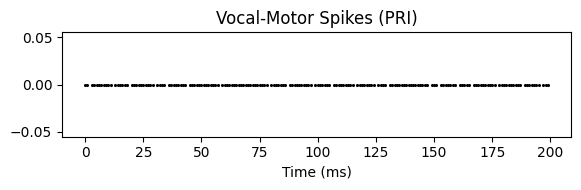

In [14]:
sim_steps = 200  # ms resolution for neural simulation
beta_tx = 0.9
threshold_tx = 1.0
lif_tx = snn.Leaky(beta=beta_tx, threshold=threshold_tx)

torch.manual_seed(0)
motor_spikes = torch.zeros(sim_steps)
mem = torch.zeros(1)

for t in range(sim_steps):
    noisy_current = 0.8 + 0.5 * torch.rand(1)  # stochastic drive
    spk, mem = lif_tx(noisy_current, mem)
    motor_spikes[t] = spk

fig, ax = plt.subplots(figsize=(6, 2))
spikeplot.raster(motor_spikes.unsqueeze(1), ax=ax, s=1.5, c="black")
ax.set_title("Vocal-Motor Spikes (PRI)")
ax.set_xlabel("Time (ms)")
plt.tight_layout()
plt.show()

## Part 3: SNN Receiver (Jeffress Coincidence Bank)
- Bank of 10 neurons (Inferior Colliculus model).
- Two inputs per neuron:
  - **Input A:** Motor spike through a delay line (self-knowledge of when it shouted).
  - **Input B:** Echo spike when sound returns.
- Preferred delays: 10, 20, …, 100 ms (Neuron 1 → 10 ms, Neuron 5 → 50 ms, Neuron 10 → 100 ms).
- Coincidence detection: neuron fires when delayed motor and echo align in time.

### Build Echo Spike Train for a Fixed Target
- Time-of-flight (two-way) determines echo delay.
- When a motor spike occurs at time `t_emit`, the echo arrives at `t_emit + delay_ms`.

Echo delay: 12 ms for 2.0 m


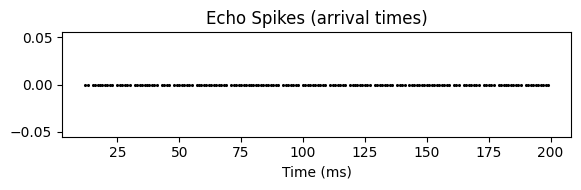

In [15]:
# Convert physical distance to ms delay (two-way)
target_distance_m = 2.0  # meters (one-way)
two_way_ms = (2 * target_distance_m / sound_speed) * 1000  # ms
echo_delay_ms = int(round(two_way_ms))
print(f"Echo delay: {echo_delay_ms} ms for {target_distance_m} m")

echo_spikes = torch.zeros(sim_steps)
for t_emit in torch.nonzero(motor_spikes, as_tuple=False).flatten():
    t_arrive = t_emit + echo_delay_ms
    if t_arrive < sim_steps:
        echo_spikes[t_arrive] = 1.0

# Visualize echo spike train
fig, ax = plt.subplots(figsize=(6, 2))
spikeplot.raster(echo_spikes.unsqueeze(1), ax=ax, s=1.5, c="black")
ax.set_title("Echo Spikes (arrival times)")
ax.set_xlabel("Time (ms)")
plt.tight_layout()
plt.show()

### Coincidence Detector Bank
- We simulate Jeffress delay lines by shifting the motor spike train for each neuron’s preferred delay.
- Input current: `I = w_motor * delayed_motor + w_echo * echo_spike`.
- Weights are set so that both inputs are needed to cross threshold in the same timestep.

In [16]:
num_neurons = 10
delays_ms = torch.arange(1, num_neurons + 1) * 10  # 10,20,...,100 ms
beta_rx = 0.85
threshold_rx = 1.0
lif_rx = snn.Leaky(beta=beta_rx, threshold=threshold_rx)

w_motor = 0.6
w_echo = 0.6

mem_rx = torch.zeros(num_neurons)
spikes_rx = torch.zeros(sim_steps, num_neurons)

for t in range(sim_steps):
    delayed_motor = torch.zeros(num_neurons)
    for i, d in enumerate(delays_ms):
        if t - d >= 0:
            delayed_motor[i] = motor_spikes[t - d]
    cur_in = w_motor * delayed_motor + w_echo * echo_spikes[t]
    spk, mem_rx = lif_rx(cur_in, mem_rx)
    spikes_rx[t] = spk

# Which neurons fired?
fired = torch.nonzero(spikes_rx.sum(dim=0) > 0, as_tuple=False).flatten() + 1
print("Neurons that fired (1-indexed):", fired.tolist())

Neurons that fired (1-indexed): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


## Part 4: Closed-Loop Visualization
- Spectrograms already show acoustic side.
- Here we plot motor spikes (top) and receiver bank spikes (bottom) to show place coding of delay.
- Expect neurons whose preferred delay matches the echo delay to light up.

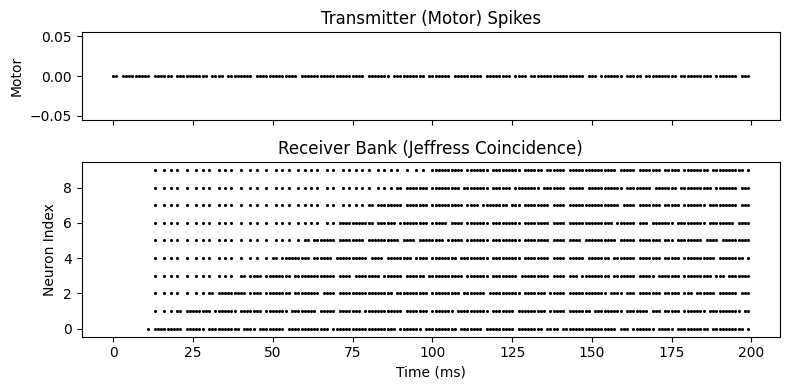

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(8, 4), sharex=True, gridspec_kw={"height_ratios": [1, 2]})
spikeplot.raster(motor_spikes.unsqueeze(1), ax=axes[0], s=1.5, c="black")
axes[0].set_title("Transmitter (Motor) Spikes")
axes[0].set_ylabel("Motor")

spikeplot.raster(spikes_rx, ax=axes[1], s=1.5, c="black")
axes[1].set_title("Receiver Bank (Jeffress Coincidence)")
axes[1].set_ylabel("Neuron Index")
axes[1].set_xlabel("Time (ms)")

plt.tight_layout()
plt.show()

### Biological Inspiration: Coincidence Detection in the Inferior Colliculus
- The delay line + coincidence mechanism is inspired by Jeffress (1948) and aligns with how bats and birds map interaural time differences and echo delays into spatial representations.
- Here, **Input A** (motor efference copy) and **Input B** (echo) must coincide in the same timestep for a neuron to fire.
- Neuron indices map directly to preferred delays (place code): Neuron 1 → 10 ms, Neuron 5 → 50 ms, Neuron 10 → 100 ms. A target distance that yields ~50 ms echo delay should preferentially activate neuron 5.